In [58]:
from distance.EuclideanDistance import EuclideanDistance
from utilities.visualization import Visualizer
from utilities.dataset_factory import DatasetFactory
from CL_utilities.top5_efficiency import top5eff
import numpy as np
import keras
from CL_utilities import loss_function
import tensorflow as tf
from livelossplot import PlotLossesKeras
from tensorflow.keras.callbacks import Callback
from utilities.test_products_generator import TestProductsGenerator
from metrics.Metrics import Metrics
from keras.optimizers import SGD

# Hyperparameters

In [59]:
image_size = (224, 224)
epochs = 3
batch_size = 16
margin = 0.5
training_pairs = 28
validation_pairs = 10
training_path = r"./data/FruitRecognition/Training"
validation_path = r"./data/FruitRecognition/Validation"

# Building training dataset 
# (1.) See Documentation to get info about structure of dataset

In [60]:
training_dataset = DatasetFactory.build_dataset(ds_path=training_path,
                                                image_size=image_size,
                                                batch_size=batch_size,
                                                max_iterations=training_pairs,
                                                method="contrastive_loss")
print(training_dataset)

<_BatchDataset element_spec=((TensorSpec(shape=(None, 224, 224, 3), dtype=tf.float32, name=None), TensorSpec(shape=(None, 224, 224, 3), dtype=tf.float32, name=None)), TensorSpec(shape=(None,), dtype=tf.float32, name=None))>


2024-05-15 12:11:08.002793: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype int32
	 [[{{node Placeholder/_0}}]]


(224, 224, 3)


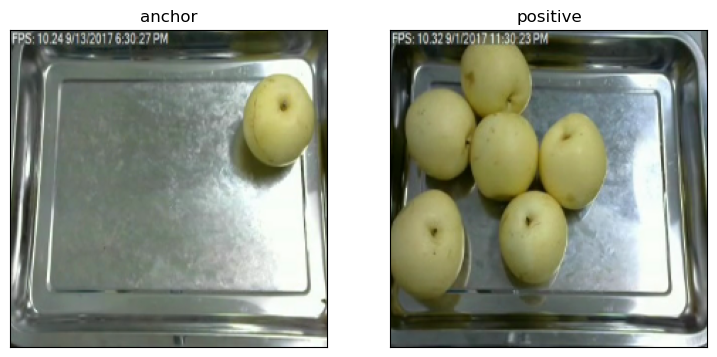

In [61]:
image, _ = next(iter(training_dataset))
anchor_img = np.asarray(image[0][0]).astype('float32')
positive_img = np.asarray(image[1][0]).astype('float32')

Visualizer.visualize(**{"anchor": anchor_img, "positive" : positive_img})
print(anchor_img.shape)

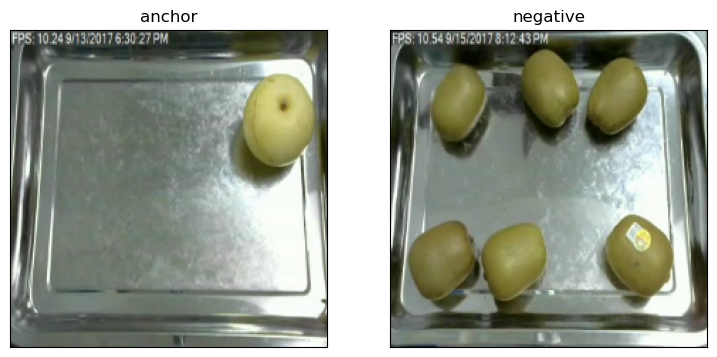

In [62]:
anchor_img = np.asarray(image[0][1]).astype('float32')
negative_img = np.asarray(image[1][1]).astype('float32')
Visualizer.visualize(**{"anchor": anchor_img, "negative" : negative_img})

# Creating validation dataset

In [63]:
validation_dataset = DatasetFactory.build_dataset(ds_path=training_path,
                                                image_size=image_size,
                                                batch_size=batch_size,
                                                max_iterations=training_pairs,
                                                method="contrastive_loss")
print(validation_dataset)

<_BatchDataset element_spec=((TensorSpec(shape=(None, 224, 224, 3), dtype=tf.float32, name=None), TensorSpec(shape=(None, 224, 224, 3), dtype=tf.float32, name=None)), TensorSpec(shape=(None,), dtype=tf.float32, name=None))>


2024-05-15 12:11:11.597967: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype int32
	 [[{{node Placeholder/_0}}]]


(224, 224, 3)


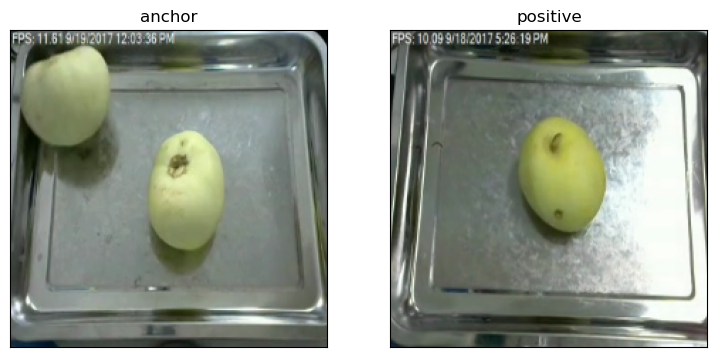

In [64]:
image, _ = next(iter(validation_dataset))
anchor_img = np.asarray(image[0][0]).astype('float32')
positive_img = np.asarray(image[1][0]).astype('float32')

Visualizer.visualize(**{"anchor": anchor_img, "positive" : positive_img})
print(anchor_img.shape)

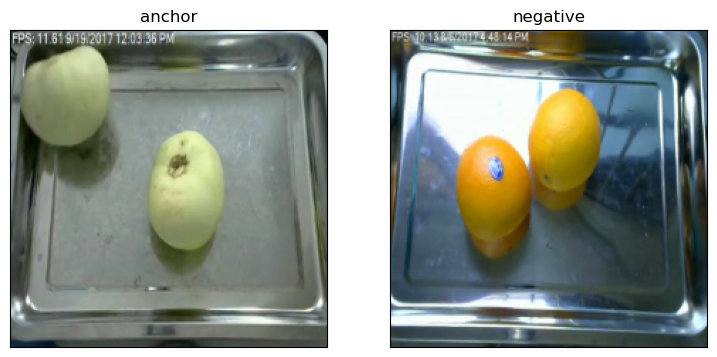

In [65]:
anchor_img = np.asarray(image[0][1]).astype('float32')
negative_img = np.asarray(image[1][1]).astype('float32')
Visualizer.visualize(**{"anchor": anchor_img, "negative" : negative_img})

In [71]:
# LOAD MODEL (TRANSFER LEARNING)

from tensorflow.keras.applications import VGG16
modelVGG = VGG16(weights='imagenet', include_top=False)

In [72]:
input_layer = keras.layers.Input((224,224,3))
x = modelVGG(input_layer)
# x = keras.layers.BatchNormalization()(input_layer)
# x = keras.layers.Conv2D(32, (5,5), activation="relu")(x)  
# x = keras.layers.AveragePooling2D(pool_size=(2,2))(x)
# x = keras.layers.Conv2D(64, (3,3), activation="relu")(x)
# x = keras.layers.AveragePooling2D(pool_size=(2,2))(x)
# x = keras.layers.Conv2D(128, (3,3), activation="relu")(x)
# x = keras.layers.AveragePooling2D(pool_size=(2,2))(x)

x = keras.layers.Flatten()(x)
x = keras.layers.Dense(32, activation="relu")(x)
x = keras.layers.BatchNormalization()(x)
x = keras.layers.Dense(16, activation="relu")(x)
x = keras.layers.Lambda(lambda x: tf.math.l2_normalize(x, axis=1))(x)
embedding_network = keras.Model(input_layer, x)   # create instance of model called embedding_network


In [75]:
input_1 = keras.layers.Input(image_size + (3,))
input_2 = keras.layers.Input(image_size + (3,))

tower_1 = embedding_network(input_1)
tower_2 = embedding_network(input_2)
 
merge_layer_distance = keras.layers.Lambda(EuclideanDistance(), output_shape=(1,))([tower_1, tower_2])
siamese = keras.Model(inputs=[input_1, input_2], outputs=merge_layer_distance)

## Load trained wages

In [89]:
#Load wages (need to have same structure of model) 
siamese.load_weights('trained_models/VGG16_32_16_testing1.h5')


#!! When loading model, the each layer.trainable must be at same comfiguration as in previous
# model. And after load_weights  : we can change trainable of layers to new configuration.

ValueError: axes don't match array

### Set what to train in transfered model:

In [77]:
#Transfer MODEL: 
# for layer in modelVGG.layers:
#     layer.trainable = False
    
    
# FineTune the last few convolutional layers
#--------------------------------------
for layers in modelVGG.layers[:-3]:
    layers.trainable = False
for layers in modelVGG.layers[-3:]:
    layers.trainable = True
#--------------------------------------


### Set learining rate and Early Stop :

In [78]:
# SET CALLBACKS
# The number of parameter "patience" has to be configured to number of epochs
# good if : n_epochs >= patience * 2
EarlyStop = keras.callbacks.EarlyStopping(monitor = 'val_loss', patience='5')

# Value of patience have to be smaller than in EarlyStopping because 
# at first try change of learning rate in next epochs
# then we can stop training if also not improve 
reduce_lr = keras.callbacks.ReduceLROnPlateau( monitor='val_loss', factor = 0.2,
                                               patience = '3', verbose=1, min_lr= 0.001,
                                               mode = 'min')


# Set optimizer

In [79]:
# Model compile for standard learning:
siamese.compile(loss=loss_function.loss(margin=margin), optimizer='adam')

# Model compile for fine-tune the last few layers of convolutional from loaded model
#-------------------------------------------------------
# sgd = SGD(learning_rate=0.1, momentum = 0.9)
# siamese.compile(loss=loss_function.loss(margin=margin), optimizer=sgd)
#-------------------------------------------------------

In [80]:
########################################################################################################################################

In [81]:
# CREATE MEAN (of 5 IMAGES) REPRESENTATIVE VECTOR FOR EACH CLASS
import tensorflow as tf
from utilities.mapping import Mapper
import os
import random
import shutil

@staticmethod
class Representatives:
    def __init__(self, image_size):
        self.list_of_images = []
        self.list_of_labels = []
        self.List_mean_feature_vector_shop = np.zeros((23,16))
        self.image_size = image_size
        
    #RANDOM_REPRESENTATIVES
    def create_representatives(self, number_of_representative):
        self.number_of_representative = number_of_representative

        shop_path = os.path.abspath("data/Fruits360/Shop360_database")
        validation_path = r"./data/Fruits360/Validation/"

        for type_of_product in os.listdir(validation_path):
            val_dir = os.path.join(validation_path, type_of_product)
            shop_class_dir = os.path.join(shop_path, type_of_product)

            os.makedirs(shop_class_dir, exist_ok=True)

            for filename in os.listdir(shop_class_dir):
                file_path = os.path.join(shop_class_dir, filename)
                os.remove(file_path)

            files = [f for f in os.listdir(val_dir)]    #list of images

            for i in range(self.number_of_representative):
                random_selected_representative = random.choice(files)
                path_representative = os.path.join(val_dir,random_selected_representative)
                destination_path = os.path.join(shop_class_dir, random_selected_representative)
                shutil.copy(path_representative, destination_path)          
    def get_mean_representatives_for_each_class(self, fruit_names, fruit_paths, number_of_representative):
        self.fruits_names = fruit_names
        self.fruits_paths = fruit_paths
        self.number_repr = number_of_representative
        i=0
        j=0

        for i in range(len(fruits_paths)):
            for j in range(self.number_repr):
                path_to_image = Mapper(image_size)
                image = path_to_image._decode_and_resize(fruits_paths[i][j])
                self.list_of_images.append(image)
                self.list_of_labels.append(fruits_names[i])
            #print(list_of_labels)
        
            #___________________Get dimensions__________________________
            num_of_images = self.number_repr#len(list_of_images[0])  #one mean for each class
            size_feature_vector = embedding_network(tf.expand_dims(self.list_of_images[0], axis=0)).numpy()
            size_feature_vector = size_feature_vector.shape[1]   #get length
            #___________________________________________________________
            
            list_class_vectors = np.zeros((num_of_images, size_feature_vector))
                
            # Get 10 different images from test 
            for num in range(self.number_repr):
                list_class_vectors[num] = embedding_network(tf.expand_dims(self.list_of_images[num], axis=0)).numpy()   
                
            mean_feature_vector = np.mean(list_class_vectors, axis=0)   # mean vector for all representatives of class
            self.List_mean_feature_vector_shop[i] = mean_feature_vector
            print(fruits_names[i])
            print(self.List_mean_feature_vector_shop[i])
        
            self.list_of_images.clear()
            self.list_of_labels.clear()
            
        return self.List_mean_feature_vector_shop

In [82]:
def distance_between_vectors(vector1, vector2):
    vector1 = vector1 / tf.norm(vector1)   # length ov vector == 1
    vector2 = vector2 / tf.norm(vector2)
    sum_square = np.sum(np.square(vector1 - vector2))
    return tf.sqrt(tf.maximum(sum_square, keras.backend.epsilon()))

In [83]:
import random
def create_test_images():
    camera_images_list = []
    camera_labels_list = []
    path_test_eff = 'data/FruitRecognition/Test'
    data = DatasetFactory.give_paths_to_test(path_test_eff, 1)
    
    
    # Get random 10 images from each class
    camera_paths = [random.sample(paths_list, 10) for paths_list in data.values() if len(paths_list) >= 10]
    camera_paths = [path for sublist in camera_paths for path in sublist]  # Spłaszczanie listy list
    camera_names = [path.split('/')[-2] for path in camera_paths]  # Zakładam, że nazwa folderu jest właściwym labelem
    
    
    camera_feature_vector = np.zeros((len(camera_paths), 16))
    print(len(camera_paths))
    # Preparing images
    for i in range(len(camera_paths)):
        path_to_image1 = Mapper(image_size)
        img  = path_to_image1._decode_and_resize(camera_paths[i])
        camera_images_list.append(img)
        camera_labels_list.append(camera_names[i])  
        camera_feature_vector[i] = embedding_network(tf.expand_dims(camera_images_list[i],axis=0)).numpy()
        
    # Calculate distances between feature vectors 
    distances = np.zeros(23)  # There are 23 classes
    for i in range(23):
        distances[i] = distance_between_vectors(camera_feature_vector, List_mean_feature_vector_shop[i])
        
    return camera_feature_vector, distances, camera_paths, camera_names

In [84]:
# To create RANDOM representatives
# num_of_imag_per_class = 10
# Representatives(image_size).create_representatives(num_of_imag_per_class)
        
camera_path = 'data/FruitRecognition/representatives/represent_5'
paths = DatasetFactory.give_paths_to_test(camera_path, 10)
fruits_names = []
fruits_paths = []
fruits_names = [key.split('/')[-1] for key in paths.keys()]
fruits_paths = [value for value in paths.values()]  # Get 5 representatives for each class



In [85]:
class CustomCallback(Callback):
    def on_epoch_end(self, epoch, logs=None):
        
        # On each epoch create new embeddings for representatives and test
        # Each epoch have better performance of model so need to create new embeddings
        num_img = 5
        object_of_representant = Representatives(image_size)
        global List_mean_feature_vector_shop
        List_mean_feature_vector_shop = object_of_representant.get_mean_representatives_for_each_class(fruits_names, fruits_paths, num_img)
        print(List_mean_feature_vector_shop)
        camera_feature_vector, distances, camera_paths, camera_names = create_test_images()
        
        # Calculate metric TOP5 Efficiency
        efficiency = 0.
        eff_one_example = 0.
        for num_camera_images in range(len(camera_paths)):  #230 (10 images for each class)
            for i in range(23):
                distances[i] = distance_between_vectors(camera_feature_vector[num_camera_images], List_mean_feature_vector_shop[i])
            top5_dist, top5_lab = top5eff().find_top_5(distances, fruits_names)
            eff_one_example = top5eff().give_efficiency(camera_names[num_camera_images], top5_lab, top5_dist)
            efficiency += eff_one_example
            
            # Print wrong classified images 
            #if(eff_one_example <= 0.92):
                #print(top5_lab)
                #print(camera_names[num_camera_images])
                #print(camera_paths[num_camera_images])
            
        efficiency = efficiency/len(camera_paths)*100
        print(f"Efficiency of model in our metric: {efficiency}")
        logs['top5_metric'] = efficiency

In [86]:
siamese.summary()

Model: "model_7"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_15 (InputLayer)          [(None, 224, 224, 3  0           []                               
                                )]                                                                
                                                                                                  
 input_16 (InputLayer)          [(None, 224, 224, 3  0           []                               
                                )]                                                                
                                                                                                  
 model_5 (Functional)           (None, 16)           15518192    ['input_15[0][0]',               
                                                                  'input_16[0][0]']         

In [87]:
########################################################################################################################################

# PARAMETERS of model

+ run:  siamese.fit if want to train new parameters
  + run: siamese.save_wages() if want to save trained parameters

+ run: siamese.load_wages() if want to load saved parameters (need to have same structure of model)

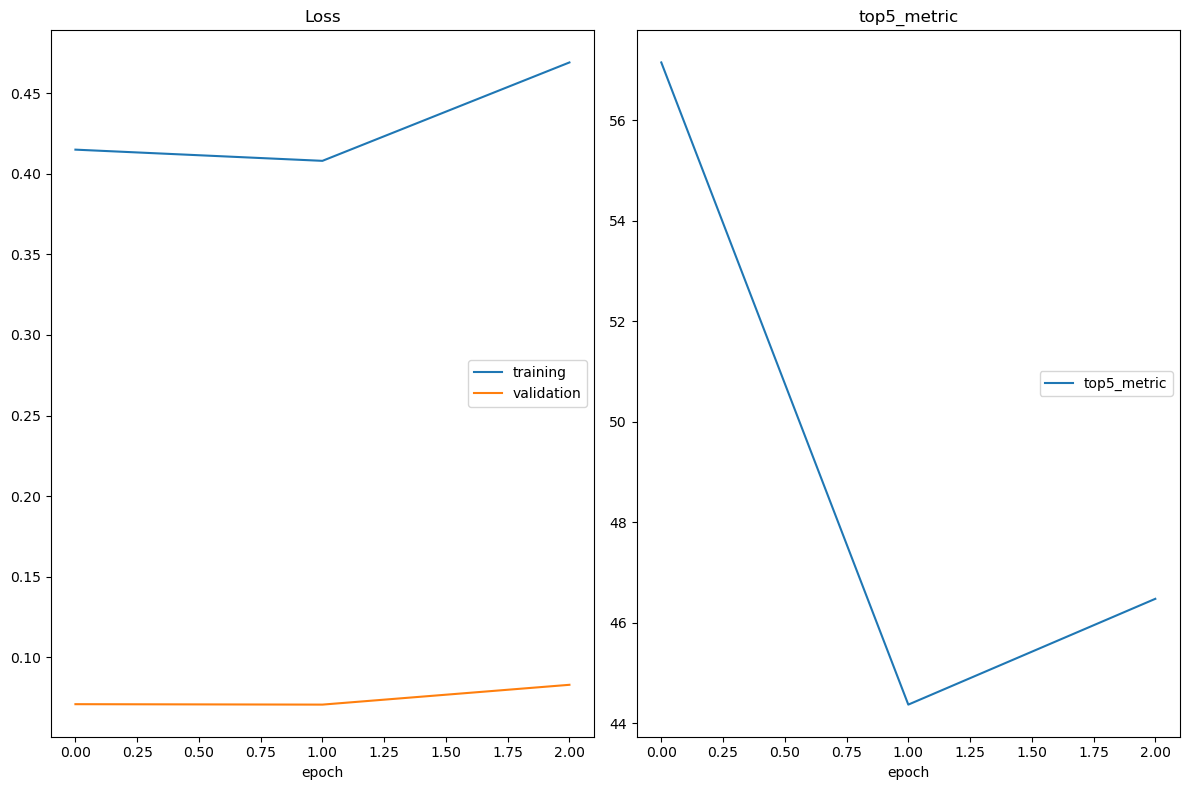

Loss
	training         	 (min:    0.408, max:    0.469, cur:    0.469)
	validation       	 (min:    0.071, max:    0.083, cur:    0.083)
top5_metric
	top5_metric      	 (min:   44.374, max:   57.148, cur:   46.478)
4/4 [==============================] - 70s 22s/step - loss: 0.4690 - val_loss: 0.0830 - top5_metric: 46.4783


In [88]:
Trained_model_data = siamese.fit(training_dataset, 
                                 validation_data= validation_dataset, 
                                 batch_size = batch_size,
                                 epochs = epochs,
                                 callbacks = [CustomCallback(), PlotLossesKeras()]
                                )

# wages:

In [25]:
#Saving wages (Only after trained model)
siamese.save_weights('trained_models/VGG16_32_16_testing1.h5')


# Create representatives

In [162]:
# CREATE MEAN (of 5 IMAGES) REPRESENTATIVE VECTOR FOR EACH CLASS
import tensorflow as tf
from utilities.mapping import Mapper
import os
import random
import shutil

@staticmethod
class Representatives:
    def __init__(self, image_size):
        self.list_of_images = []
        self.list_of_labels = []
        self.List_mean_feature_vector_shop = np.zeros((23,16))
        self.image_size = image_size
        
    #RANDOM_REPRESENTATIVES
    def create_representatives(self, number_of_representative):
        self.number_of_representative = number_of_representative

        shop_path = os.path.abspath("data/FruitRecognition/Shop_database")
        validation_path = r"./data/FruitRecognition/Validation/"

        for type_of_product in os.listdir(validation_path):
            val_dir = os.path.join(validation_path, type_of_product)
            shop_class_dir = os.path.join(shop_path, type_of_product)

            os.makedirs(shop_class_dir, exist_ok=True)

            for filename in os.listdir(shop_class_dir):
                file_path = os.path.join(shop_class_dir, filename)
                os.remove(file_path)

            files = [f for f in os.listdir(val_dir)]    #list of images

            for i in range(self.number_of_representative):
                random_selected_representative = random.choice(files)
                path_representative = os.path.join(val_dir,random_selected_representative)
                destination_path = os.path.join(shop_class_dir, random_selected_representative)
                shutil.copy(path_representative, destination_path)          
    def get_mean_representatives_for_each_class(self, fruit_names, fruit_paths, number_of_representative):
        self.fruits_names = fruit_names
        self.fruits_paths = fruit_paths
        self.number_repr = number_of_representative
        i=0
        j=0

        for i in range(len(fruits_paths)):
            for j in range(self.number_repr):
                path_to_image = Mapper(image_size)
                image = path_to_image._decode_and_resize(fruits_paths[i][j])
                self.list_of_images.append(image)
                self.list_of_labels.append(fruits_names[i])
            #print(list_of_labels)
        
            #___________________Get dimensions__________________________
            num_of_images = self.number_repr#len(list_of_images[0])  #one mean for each class
            size_feature_vector = embedding_network(tf.expand_dims(self.list_of_images[0], axis=0)).numpy()
            size_feature_vector = size_feature_vector.shape[1]   #get length
            #___________________________________________________________
            
            list_class_vectors = np.zeros((num_of_images, size_feature_vector))
                
            for num in range(self.number_repr):
                list_class_vectors[num] = embedding_network(tf.expand_dims(self.list_of_images[num], axis=0)).numpy()
            #print(list_class_vectors)    
                
            mean_feature_vector = np.mean(list_class_vectors, axis=0)   # mean vector for all representatives of class
            self.List_mean_feature_vector_shop[i] = mean_feature_vector
            print(fruits_names[i])
            print(self.List_mean_feature_vector_shop[i])
        
            self.list_of_images.clear()
            self.list_of_labels.clear()
            
        return self.List_mean_feature_vector_shop
    

In [105]:
# NEW SET OF REPRESENTATIVES  (changing images in file Dataset_shop)
# RANDOM_REPRESENTATIVES
# num_of_imag_per_class = 10
# Representatives(image_size).create_representatives(num_of_imag_per_class)

In [163]:
# Loading Representatives from dataset_shop

camera_path = 'data/FruitRecognition/representatives/represent_5'
paths = DatasetFactory.give_paths_to_test(camera_path, 10)

fruits_names = []
fruits_paths = []
fruits_names = [key.split('/')[-1] for key in paths.keys()]
fruits_paths = [value for value in paths.values()]  # Get 5 representatives for each class
#print((fruits_paths[0][4]))


In [164]:
# CREATE MEAN (of num_img IMAGES) REPRESENTATIVE VECTOR FOR EACH CLASS
num_img = 5
object_of_representant = Representatives(image_size)
List_mean_feature_vector_shop = object_of_representant.get_mean_representatives_for_each_class(fruits_names, fruits_paths, num_img)
# List_mean_feature_vector_shop = Representatives(image_size).get_mean_representatives_for_each_class(fruits_names, fruits_paths, num_img)


muskmelon
[0.0623 0.0428 0.4918 0.117  0.4072 0.3989 0.2935 0.1099 0.2313 0.0007
 0.2227 0.0849 0.0032 0.0064 0.4448 0.    ]
Kiwi C
[5.3108e-03 6.2167e-04 4.8692e-01 0.0000e+00 5.0892e-01 3.0015e-01
 1.5614e-01 6.8297e-02 2.5235e-02 1.8015e-01 2.0135e-01 5.2743e-04
 0.0000e+00 0.0000e+00 5.4833e-01 0.0000e+00]
Apple A
[0.0075 0.     0.5104 0.0868 0.428  0.3331 0.2123 0.1039 0.2037 0.002
 0.2374 0.0659 0.     0.     0.5223 0.    ]
Apple C
[0.0078 0.     0.4975 0.0213 0.4202 0.301  0.1448 0.1279 0.1139 0.0044
 0.2634 0.0228 0.     0.     0.5984 0.    ]
Carambola
[0.2944 0.2425 0.3291 0.1253 0.2945 0.5364 0.2797 0.1007 0.0408 0.
 0.1872 0.0256 0.0058 0.2281 0.3494 0.0143]
guava A
[0.1445 0.1021 0.4232 0.1083 0.5132 0.3839 0.3678 0.1138 0.2803 0.0236
 0.1971 0.0928 0.0341 0.0521 0.2921 0.    ]
Mango
[0.0813 0.0595 0.4758 0.1082 0.4406 0.4069 0.3083 0.101  0.2162 0.0029
 0.2147 0.0803 0.0055 0.0289 0.4137 0.    ]
guava B
[0.     0.     0.537  0.1006 0.436  0.3193 0.2278 0.1011 0.2467 0.0039

# Distances

In [98]:
def distance_between_vectors(vector1, vector2):
    vector1 = vector1 / tf.norm(vector1)   # length ov vector == 1
    vector2 = vector2 / tf.norm(vector2)
    sum_square = np.sum(np.square(vector1 - vector2))
    return tf.sqrt(tf.maximum(sum_square, keras.backend.epsilon()))

In [99]:
np.set_printoptions(precision=4)

distance1 = distance_between_vectors(List_mean_feature_vector_shop[0], List_mean_feature_vector_shop[16])
distance2 = distance_between_vectors(List_mean_feature_vector_shop[7], List_mean_feature_vector_shop[20])

print(f"Distance between {fruits_names[0]} and {fruits_names[16]}  == {distance1}")
print(f"Distance between {fruits_names[7]} and {fruits_names[20]}  == {distance2}\n")



Distance between muskmelon and Tomatoes  == 0.43072314256286265
Distance between guava B and Plum  == 0.41929843873551004


# Create test images

In [166]:
import random
def create_test_images():
    camera_images_list = []
    camera_labels_list = []
    path_test_eff = 'data/FruitRecognition/Test'
    data = DatasetFactory.give_paths_to_test(path_test_eff, 1)
    
    
    # Losowo wybieranie 10 zdjęć z każdego folderu
    camera_paths = [random.sample(paths_list, 10) for paths_list in data.values() if len(paths_list) >= 10]
    camera_paths = [path for sublist in camera_paths for path in sublist]  # Spłaszczanie listy list
    camera_names = [path.split('/')[-2] for path in camera_paths]  # Zakładam, że nazwa folderu jest właściwym labelem
    
    
    camera_feature_vector = np.zeros((len(camera_paths), 16))
    print(len(camera_paths))
    # Dekodowanie i przetwarzanie obrazów
    for i in range(len(camera_paths)):
        path_to_image1 = Mapper(image_size)
        img  = path_to_image1._decode_and_resize(camera_paths[i])
        camera_images_list.append(img)
        camera_labels_list.append(camera_names[i])  
        camera_feature_vector[i] = embedding_network(tf.expand_dims(camera_images_list[i],axis=0)).numpy()
        
    # Obliczanie odległości między wektorami cech
    distances = np.zeros(23)  # Zakładam, że istnieje 22 kategorie
    for i in range(23):
        distances[i] = distance_between_vectors(camera_feature_vector, List_mean_feature_vector_shop[i])
        
    return camera_feature_vector, distances, camera_paths, camera_names

In [167]:
camera_feature_vector, distances, camera_paths, camera_names = create_test_images()

230


# Creating a generator for test images

In [83]:
# test_path = 'data/FruitRecognition/Test'
# test_generator = TestProductsGenerator(test_path)

# Find top5 efficiency of model and more info

In [84]:
print(object_of_representant.fruits_names[0])
print(len(List_mean_feature_vector_shop))

muskmelon
23


In [85]:
# efficiency = 0.
# test_length = 0.
# mapper = Mapper(image_size)
# 
# for _ in range(10):
#     l, p = next(iter(test_generator.get_next_element()))
#     label, image = mapper.map_single_product(l,p)
#     label = label.rsplit('/', 1)[1]
#     image_path = p
#     image = tf.reshape(image, shape=(1,) + image_size + (3,))
#     embedding = np.asarray(embedding_network(image)).astype('float32')
#     distances = np.zeros(len(List_mean_feature_vector_shop)) #23
#     labels = []
#     efficiency_sum = 0
#     for i in range(len(List_mean_feature_vector_shop)):
#         distances[i] = EuclideanDistance.calculate_distance((embedding, List_mean_feature_vector_shop[i]))
#         labels.append(object_of_representant.fruits_names[i])
#     top5_dist, top5_labels = Metrics.find_top_5(distances, labels)
#     efficiency_sum += Metrics.calculate_efficiency(label, top5_labels)
#     print(label)
#     print(top5_labels)
#     test_length += 1
#     
# overall_efficiency = efficiency_sum / test_length
# print(overall_efficiency)
#     
#     
    

muskmelon
['Pear', 'guava A', 'muskmelon', 'Apple F', 'Apple D']
muskmelon
['Pear', 'guava A', 'muskmelon', 'Apple F', 'Apple D']
muskmelon
['Pear', 'guava A', 'muskmelon', 'Apple F', 'Apple D']
muskmelon
['Pear', 'guava A', 'muskmelon', 'Apple F', 'Apple D']
muskmelon
['Pear', 'guava A', 'muskmelon', 'Apple F', 'Apple D']
muskmelon
['Pear', 'guava A', 'muskmelon', 'Apple F', 'Apple D']
muskmelon
['Pear', 'guava A', 'muskmelon', 'Apple F', 'Apple D']
muskmelon
['Pear', 'guava A', 'muskmelon', 'Apple F', 'Apple D']
muskmelon
['Pear', 'guava A', 'muskmelon', 'Apple F', 'Apple D']
muskmelon
['Pear', 'guava A', 'muskmelon', 'Apple F', 'Apple D']
0.096


In [168]:
efficiency = 0.
eff_one_example = 0.
for num_camera_images in range(len(camera_paths)):  #230 (10 images for each class)
    for i in range(23):
        distances[i] = distance_between_vectors(camera_feature_vector[num_camera_images], List_mean_feature_vector_shop[i])
    top5_dist, top5_lab = top5eff().find_top_5(distances, fruits_names)
    eff_one_example = top5eff().give_efficiency(camera_names[num_camera_images], top5_lab, top5_dist)
    efficiency += eff_one_example
    if(eff_one_example <= 0.92):
        print(top5_lab)
        print(camera_names[num_camera_images])
        print(camera_paths[num_camera_images])
efficiency = efficiency/len(camera_paths)*100
print(f"Efficiency of model in our metric: {efficiency}")

['Apple A', 'guava B', 'Apple D', 'Peach', 'muskmelon']
muskmelon
data/FruitRecognition/Test/muskmelon/Muskmelon 001523.png
['Orange', 'Tomatoes', 'Mango', 'Peach', 'muskmelon']
muskmelon
data/FruitRecognition/Test/muskmelon/Muskmelon 001247.png
['Mango', 'Pear', 'Apple F', 'guava A', 'Orange']
muskmelon
data/FruitRecognition/Test/muskmelon/Muskmelon 001372.png
['Apple F', 'Pear', 'Mango', 'Orange', 'muskmelon']
muskmelon
data/FruitRecognition/Test/muskmelon/Muskmelon 00129.png
['Orange', 'Pomegranate', 'Apple F', 'Mango', 'Tomatoes']
Carambola
data/FruitRecognition/Test/Carambola/Carambola 00771.png
['Mango', 'Orange', 'muskmelon', 'Pear', 'Apple F']
guava A
data/FruitRecognition/Test/guava A/ene07201.png
['Mango', 'Pear', 'Orange', 'muskmelon', 'Apple F']
guava A
data/FruitRecognition/Test/guava A/scene13081.png
['Mango', 'Pear', 'muskmelon', 'Orange', 'Apple D']
guava A
data/FruitRecognition/Test/guava A/ene04501.png
['Carambola', 'Pomegranate', 'Apple F', 'guava A', 'Mango']
Mango
